### Predicting the number of problems per km2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from feature_engine.creation import CyclicalFeatures
import vonMisesMixtures as vonmises

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import r2_score, f1_score

import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
SMALL_SIZE = 8 # points
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.rcParams['figure.facecolor']   = 'white'
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.facecolor']     = 'white'
plt.rcParams['axes.spines.right']  = False
plt.rcParams['axes.spines.top']    = False
plt.rcParams['font.family']        = 'sans-serif'
plt.rcParams['font.sans-serif']    = ['Arial', 'DejaVu']
plt.rcParams['savefig.dpi']        = 300
plt.rcParams['svg.fonttype']       = 'none'
plt.rcParams['pdf.fonttype']       = 42
plt.rcParams['ps.fonttype']        = 42

cm = 1/2.54  # centimeters in inches
single_col = 8.9*cm
oneDot5_col = 12.7*cm
two_col = 18.2*cm

In [3]:
input_folder  = './processed_db'
output_folder = './files_ML_problemsPerKm2_completeDB'

In [4]:
df = pd.read_csv('{}/db_criminalBehaviour_DateRegional.csv'.format(input_folder))
df.drop(['categories', 'Unnamed: 0', 'hour_rads'], axis=1, inplace=True)

df = df.rename(columns={"time": "hour", "problem_type_1": "problem"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81192 entries, 0 to 81191
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               81192 non-null  int64  
 1   month              81192 non-null  int64  
 2   week_day           81192 non-null  object 
 3   hour               81192 non-null  int64  
 4   regional_name      81192 non-null  object 
 5   problem            81192 non-null  object 
 6   count              81192 non-null  int64  
 7   nProb_km2          81124 non-null  float64
 8   avg_monthlyIncome  81124 non-null  float64
 9   pop_km2            81124 non-null  float64
 10  people_house       81124 non-null  float64
dtypes: float64(4), int64(4), object(3)
memory usage: 6.8+ MB


In [5]:
df.dropna(how='any', inplace=True)

In [6]:
problems2drop = list(set(df.loc[df.year<2021, 'problem']) - set(df.loc[df.year>=2021, 'problem']))


In [7]:
problems2drop.extend(['Non-compliance with law 15799/2021 COVID-19', 'Stalking', 'Incitement to crime', 'Prevarication (corruption)',
                      'Obstruction of Police Activity'])
problems2drop

['Quackery',
 'Concussion (corruption)',
 'Gang',
 'Prohibited sale of specific products to minors',
 'Omission of assistance',
 'Favouring prostitution',
 'Sexual assault/rape',
 'Arbitrary violence',
 'Procuring/Pimping (prostitution)',
 'Corruption',
 'Possession of explosive device',
 'Crime apology',
 'Embezzlement',
 'Defamation',
 'Non-compliance with law 15799/2021 COVID-19',
 'Stalking',
 'Incitement to crime',
 'Prevarication (corruption)',
 'Obstruction of Police Activity']

In [8]:
idx2drop = df[df.problem.isin(problems2drop)].index
df.drop(index=idx2drop, axis=0, inplace=True)

In [9]:
df.describe()

,year,month,hour,count,nProb_km2,avg_monthlyIncome,pop_km2,people_house
count,80823.000000,80823.000000,80823.000000,80823.000000,80823.000000,80823.000000,80823.000000,80823.000000
mean,2016.225183,6.451740,14.213405,1.109783,0.029332,1756.693998,4496.997092,3.192154
std,3.783178,3.449576,6.039100,0.422934,0.016424,846.916025,1398.726735,0.540170
min,2009.000000,1.000000,0.000000,1.000000,0.015601,518.000000,1126.000000,2.580000
25%,2013.000000,3.000000,10.000000,1.000000,0.022321,1338.000000,3630.000000,2.770000
50%,2016.000000,6.000000,15.000000,1.000000,0.025126,1516.000000,4728.000000,3.150000
75%,2019.000000,9.000000,19.000000,1.000000,0.027548,2897.000000,5573.000000,3.500000
max,2022.000000,12.000000,23.000000,14.000000,0.443038,2897.000000,6193.000000,4.550000


In [10]:
df.head()

,year,month,week_day,hour,regional_name,problem,count,nProb_km2,avg_monthlyIncome,pop_km2,people_house
0,2009,1,1-Sunday,0,MATRIZ,Agression,1,0.027548,2897.0,5573.0,2.77
1,2009,1,1-Sunday,0,MATRIZ,Robbery,1,0.027548,2897.0,5573.0,2.77
2,2009,1,1-Sunday,0,PORTÃO,Robbery,1,0.025126,1516.0,6193.0,3.15
3,2009,1,1-Sunday,1,BOQUEIRÃO,Break-in,1,0.025126,1338.0,4728.0,3.50
4,2009,1,1-Sunday,1,MATRIZ,Theft,1,0.027548,2897.0,5573.0,2.77


In [11]:
df['week_day'] = [int(x.split('-')[0]) for x in df['week_day']]

In [12]:
cyclical = CyclicalFeatures(variables=['month', 'week_day', 'hour'], drop_original=False)

df = cyclical.fit_transform(df)

In [13]:
df

,year,month,week_day,hour,regional_name,problem,count,nProb_km2,avg_monthlyIncome,pop_km2,people_house,month_sin,month_cos,week_day_sin,week_day_cos,hour_sin,hour_cos
0,2009,1,1,0,MATRIZ,Agression,1,0.027548,2897.0,5573.0,2.77,5.000000e-01,0.866025,7.818315e-01,0.62349,0.000000e+00,1.000000
1,2009,1,1,0,MATRIZ,Robbery,1,0.027548,2897.0,5573.0,2.77,5.000000e-01,0.866025,7.818315e-01,0.62349,0.000000e+00,1.000000
2,2009,1,1,0,PORTÃO,Robbery,1,0.025126,1516.0,6193.0,3.15,5.000000e-01,0.866025,7.818315e-01,0.62349,0.000000e+00,1.000000
3,2009,1,1,1,BOQUEIRÃO,Break-in,1,0.025126,1338.0,4728.0,3.50,5.000000e-01,0.866025,7.818315e-01,0.62349,2.697968e-01,0.962917
4,2009,1,1,1,MATRIZ,Theft,1,0.027548,2897.0,5573.0,2.77,5.000000e-01,0.866025,7.818315e-01,0.62349,2.697968e-01,0.962917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81187,2022,12,7,22,CIC,Violation of Protective Measures for women - L...,1,0.016234,523.0,2698.0,3.63,-2.449294e-16,1.000000,-2.449294e-16,1.00000,-2.697968e-01,0.962917
81188,2022,12,7,22,PINHEIRINHO,Violation of Protective Measures for women - L...,1,0.063291,842.0,3942.0,2.58,-2.449294e-16,1.000000,-2.449294e-16,1.00000,-2.697968e-01,0.962917
81189,2022,12,7,22,TATUQUARA,Violation of Protective Measures for women - L...,1,0.024390,518.0,1126.0,3.81,-2.449294e-16,1.000000,-2.449294e-16,1.00000,-2.697968e-01,0.962917
81190,2022,12,7,23,BOQUEIRÃO,Physical/Verbal Agression,1,0.025126,1338.0,4728.0,3.50,-2.449294e-16,1.000000,-2.449294e-16,1.00000,-2.449294e-16,1.000000


In [14]:
df.problem.unique()

array(['Agression', 'Robbery', 'Break-in', 'Theft', 'Illitcit Substance',
       'Physical/Verbal Agression', 'Environmental crime',
       'Illegal possession', 'Obscene/libelous acts', 'Gunshot',
       'Sexual harassment', 'Extortion', 'Corporal injury',
       'Misuse of transport card', 'Fishing in Prohibited Places',
       'Abandonment/nonsupport of incompetent person', 'Maltreatment',
       'Supplying alcohol to minors', 'False money',
       'Irregular Construction', 'Murder',
       'Abuse of incapacitated persons', 'Gambling', 'Rape',
       'Fraud (monetary)', 'False Identity', 'Prostitution',
       'Crime against individual liberty', 'Kidnapping and imprisonment',
       'Child grooming/enticement',
       'Loss, concealment or destruction of books or documents',
       'Gang-sacking/pillaging', 'Irregular landfill',
       'Violation of graves',
       'Wearing a uniform, or badge of a public function that he does not exercise',
       'Smuggling/contraband', 'Exploitat

In [248]:
problems2vis = [
    'Agression', 
       'Gunshot', 'Robbery', 
       'Kidnapping and imprisonment', 'Murder', 
       'Maltreatment', 'Rape',
       'Sexual harassment','Exploitation of minors',
]

Plots

In [122]:
num_features = ['year', 'month', 'week_day', 'hour','nProb_km2','avg_monthlyIncome','pop_km2','people_house']

<Axes: >

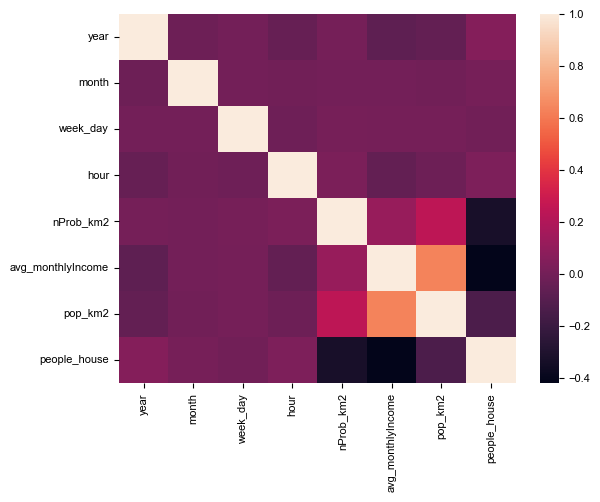

In [228]:
sns.heatmap(df[num_features].corr('pearson'))

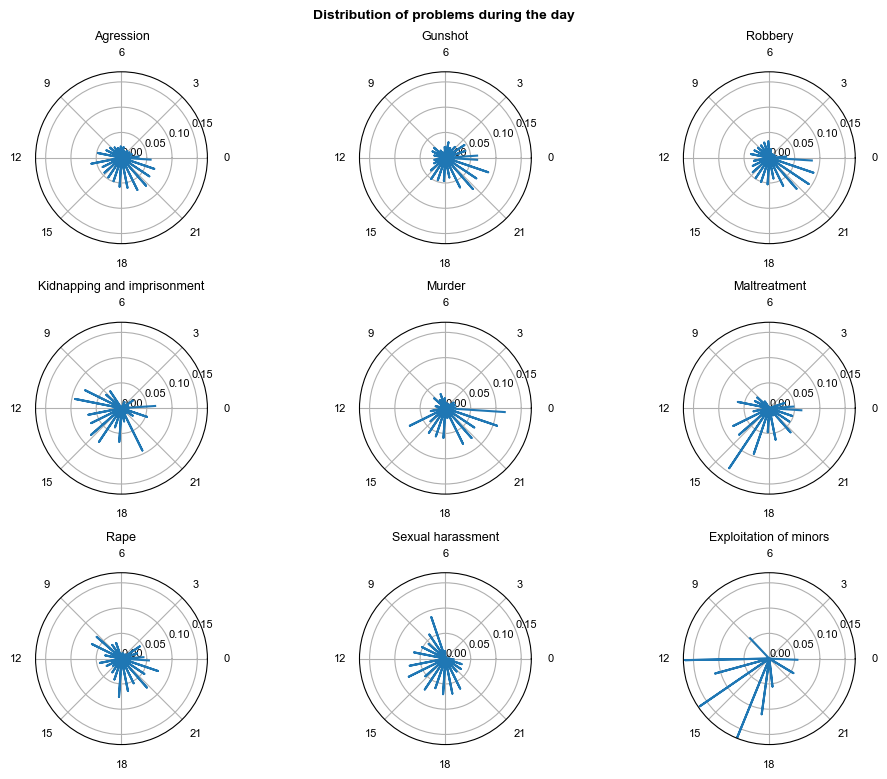

In [229]:
number_of_bins = 48

idxPlot = 1
plt.figure(figsize=(25*cm, 20*cm))
plt.suptitle('Distribution of problems during the day')
for prob in problems2vis:
    dt2plot = df[(df['problem']==prob)].copy()
    
    dt2plot["hour_rads"] = dt2plot["hour"] * (2.0 * np.pi / dt2plot["hour"].max())
    dt2plot = dt2plot.sort_values('hour')
    # print(dt2plot[['hour', 'hour_rads']])

    x_histo = vonmises.tools.histogram(dt2plot['hour_rads'],bins=number_of_bins)

    ax = plt.subplot(3,3,idxPlot, projection='polar')
    plt.plot(x_histo[0], x_histo[1])
    plt.title(prob)
    plt.xticks(ax.get_xticks(), labels=np.arange(0,24,step=3)) 
    plt.ylim([0,0.17])
    plt.yticks(np.arange(0,0.17, step=0.05))
    idxPlot += 1

plt.tight_layout()

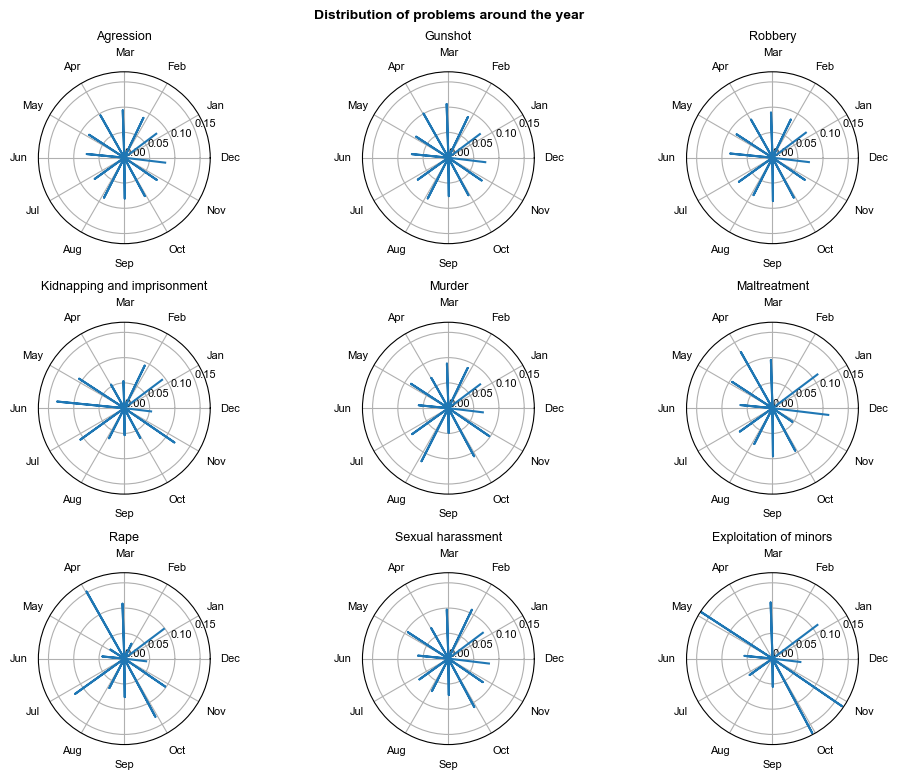

In [230]:
number_of_bins = 24
ticks = np.arange(1,13,1) * (2.0 * np.pi / dt2plot["month"].max())
idxPlot = 1
plt.figure(figsize=(25*cm, 20*cm))
plt.suptitle('Distribution of problems around the year')
for prob in problems2vis:
    dt2plot = df[(df['problem']==prob)].copy()
    
    dt2plot["month_rads"] = dt2plot["month"] * (2.0 * np.pi / (dt2plot["month"].max()))
    dt2plot = dt2plot.sort_values('month')
    # print(dt2plot.month_rads,dt2plot.month)
    
    x_histo = vonmises.tools.histogram(dt2plot['month_rads'],bins=number_of_bins)

    ax = plt.subplot(3,3,idxPlot, projection='polar')
    plt.plot(x_histo[0], x_histo[1])
    plt.title(prob)
    
    plt.xticks(ticks, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) 
    plt.ylim([0,0.17])
    plt.yticks(np.arange(0,0.17, step=0.05))
    idxPlot += 1

plt.tight_layout()

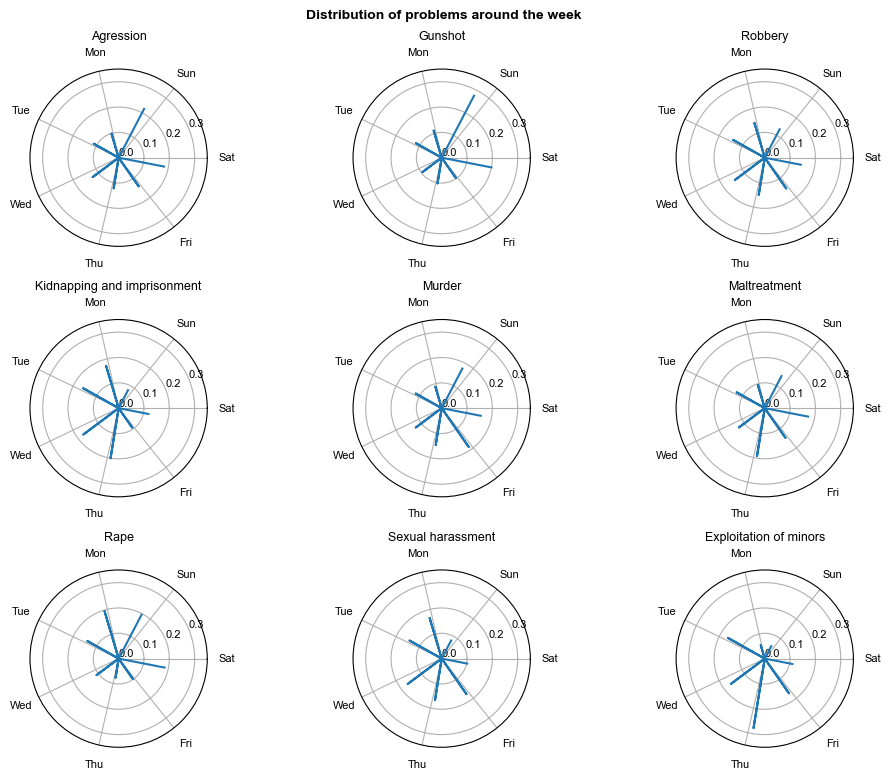

In [231]:
number_of_bins = 14
ticks = np.arange(1,8,1) * (2.0 * np.pi / dt2plot["week_day"].max())
idxPlot = 1
plt.figure(figsize=(25*cm, 20*cm))
plt.suptitle('Distribution of problems around the week')
for prob in problems2vis:
    dt2plot = df[(df['problem']==prob)].copy()
    
    dt2plot["week_day_rads"] = dt2plot["week_day"] * (2.0 * np.pi / (dt2plot["week_day"].max()))
    dt2plot = dt2plot.sort_values('week_day')
    # print(dt2plot.month_rads,dt2plot.month)
    
    x_histo = vonmises.tools.histogram(dt2plot['week_day_rads'],bins=number_of_bins)

    ax = plt.subplot(3,3,idxPlot, projection='polar')
    plt.plot(x_histo[0], x_histo[1])
    plt.title(prob)
    
    plt.xticks(ticks, labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']) 
    plt.yticks(np.arange(0,0.32, step=0.1))
    plt.ylim([0,0.35])
    idxPlot += 1

plt.tight_layout()

In [232]:
plt.figure(figsize=(30*cm, 15*cm))
sns.barplot(data=df[df.problem_type_1.isin(problems2vis)], x='nProb_km2', y='problem_type_1', hue='regional_name', orient='h', palette='hsv')

AttributeError: 'DataFrame' object has no attribute 'problem_type_1'

<Figure size 1181.1x590.551 with 0 Axes>

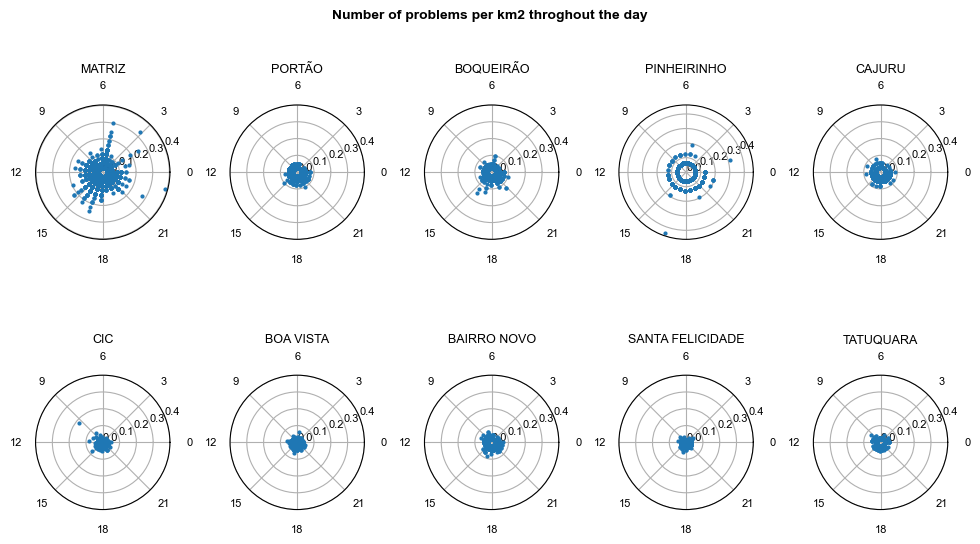

In [249]:
idxPlot = 1
plt.figure(figsize=(25*cm, 15*cm))
plt.suptitle('Number of problems per km2 throghout the day')
for reg in df.regional_name.unique():
    dt2plot = df[(df['regional_name']==reg)].copy()
    dt2plot["hour_rads"] = dt2plot["hour"] * (2.0 * np.pi / dt2plot["hour"].max())
    dt2plot = dt2plot.sort_values('hour')

    ax = plt.subplot(2,5,idxPlot, projection='polar')
    plt.plot(dt2plot['hour_rads'], dt2plot['nProb_km2'], marker='o', linestyle='', markersize=2)
    plt.title(reg)
    plt.xticks(ax.get_xticks(), labels=np.arange(0,24,step=3)) 
    # if reg == 'MATRIZ':
    #     plt.yticks(np.arange(0,22, step=5))
    #     plt.ylim([0,22])
    # else:
    plt.yticks(np.arange(0,.44, step=.1))
    # plt.ylim([0,11])
    idxPlot += 1
plt.tight_layout()

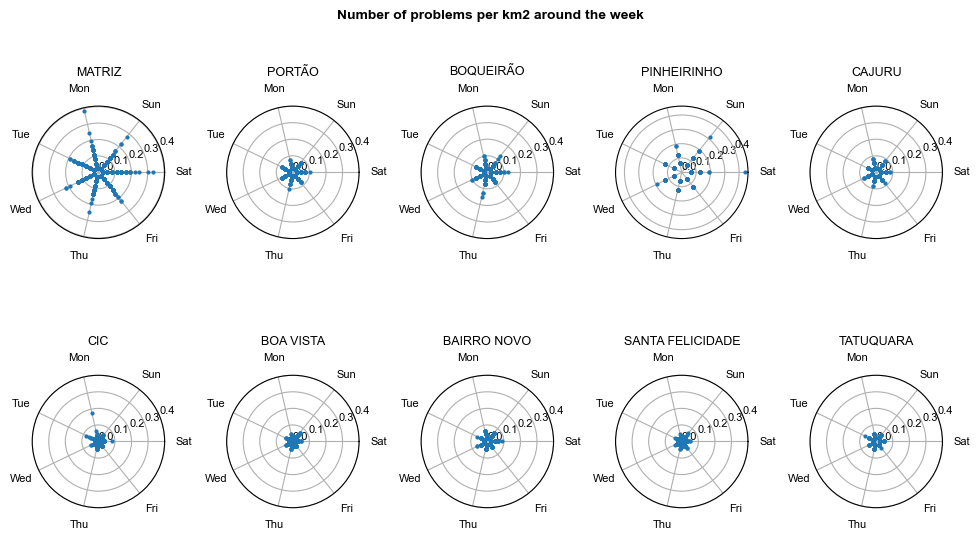

In [250]:
ticks = np.arange(1,8,1) * (2.0 * np.pi / dt2plot["week_day"].max())

idxPlot = 1
plt.figure(figsize=(25*cm, 15*cm))
plt.suptitle('Number of problems per km2 around the week')
for reg in df.regional_name.unique():
    dt2plot = df[(df['regional_name']==reg)].copy()
    dt2plot["week_day_rads"] = dt2plot["week_day"] * (2.0 * np.pi / dt2plot["week_day"].max())
    dt2plot = dt2plot.sort_values('week_day')

    ax = plt.subplot(2,5,idxPlot, projection='polar')
    plt.plot(dt2plot['week_day_rads'], dt2plot['nProb_km2'], marker='o', linestyle='', markersize=2)
    plt.title(reg)
    plt.xticks(ticks, labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']) 
    plt.yticks(np.arange(0,.44, step=.1))
    idxPlot += 1
plt.tight_layout()

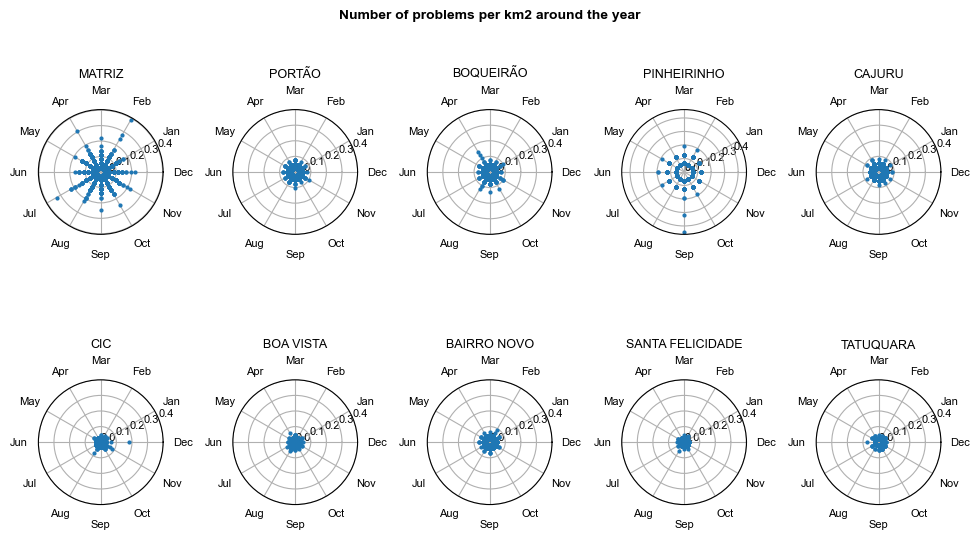

In [251]:
ticks = np.arange(1,13,1) * (2.0 * np.pi / dt2plot["month"].max())

idxPlot = 1
plt.figure(figsize=(25*cm, 15*cm))
plt.suptitle('Number of problems per km2 around the year')
for reg in df.regional_name.unique():
    dt2plot = df[(df['regional_name']==reg)].copy()
    dt2plot["month_rads"] = dt2plot["month"] * (2.0 * np.pi / dt2plot["month"].max())
    dt2plot = dt2plot.sort_values('month')

    ax = plt.subplot(2,5,idxPlot, projection='polar')
    plt.plot(dt2plot['month_rads'], dt2plot['nProb_km2'], marker='o', linestyle='', markersize=2)
    plt.title(reg)
    plt.xticks(ticks, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) 
    plt.yticks(np.arange(0,.44, step=.1))
    idxPlot += 1
plt.tight_layout()

Defining a test set:

In [252]:
df

,year,month,week_day,hour,regional_name,problem,count,nProb_km2,avg_monthlyIncome,pop_km2,people_house,month_sin,month_cos,week_day_sin,week_day_cos,hour_sin,hour_cos
0,2009,1,1,0,MATRIZ,Agression,1,0.027548,2897.0,5573.0,2.77,5.000000e-01,0.866025,7.818315e-01,0.62349,0.000000e+00,1.000000
1,2009,1,1,0,MATRIZ,Robbery,1,0.027548,2897.0,5573.0,2.77,5.000000e-01,0.866025,7.818315e-01,0.62349,0.000000e+00,1.000000
2,2009,1,1,0,PORTÃO,Robbery,1,0.025126,1516.0,6193.0,3.15,5.000000e-01,0.866025,7.818315e-01,0.62349,0.000000e+00,1.000000
3,2009,1,1,1,BOQUEIRÃO,Break-in,1,0.025126,1338.0,4728.0,3.50,5.000000e-01,0.866025,7.818315e-01,0.62349,2.697968e-01,0.962917
4,2009,1,1,1,MATRIZ,Theft,1,0.027548,2897.0,5573.0,2.77,5.000000e-01,0.866025,7.818315e-01,0.62349,2.697968e-01,0.962917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81187,2022,12,7,22,CIC,Violation of Protective Measures for women - L...,1,0.016234,523.0,2698.0,3.63,-2.449294e-16,1.000000,-2.449294e-16,1.00000,-2.697968e-01,0.962917
81188,2022,12,7,22,PINHEIRINHO,Violation of Protective Measures for women - L...,1,0.063291,842.0,3942.0,2.58,-2.449294e-16,1.000000,-2.449294e-16,1.00000,-2.697968e-01,0.962917
81189,2022,12,7,22,TATUQUARA,Violation of Protective Measures for women - L...,1,0.024390,518.0,1126.0,3.81,-2.449294e-16,1.000000,-2.449294e-16,1.00000,-2.697968e-01,0.962917
81190,2022,12,7,23,BOQUEIRÃO,Physical/Verbal Agression,1,0.025126,1338.0,4728.0,3.50,-2.449294e-16,1.000000,-2.449294e-16,1.00000,-2.449294e-16,1.000000


In [15]:
y_probKm2 = np.array(list(df.nProb_km2))
y_prob    = np.array(list(df.problem))
X = df.drop(['count', 'nProb_km2', 'problem', 'month', 'week_day', 'hour'], axis=1)

In [16]:
y_probKm2

array([0.02754821, 0.02754821, 0.02512563, ..., 0.02439024, 0.02512563,
       0.01623377])

In [17]:
y_prob

array(['Agression', 'Robbery', 'Robbery', ...,
       'Violation of Protective Measures for women - Lei Maria da Penha',
       'Physical/Verbal Agression', 'Break-in'], dtype='<U74')

In [18]:
X

,year,regional_name,avg_monthlyIncome,pop_km2,people_house,month_sin,month_cos,week_day_sin,week_day_cos,hour_sin,hour_cos
0,2009,MATRIZ,2897.0,5573.0,2.77,5.000000e-01,0.866025,7.818315e-01,0.62349,0.000000e+00,1.000000
1,2009,MATRIZ,2897.0,5573.0,2.77,5.000000e-01,0.866025,7.818315e-01,0.62349,0.000000e+00,1.000000
2,2009,PORTÃO,1516.0,6193.0,3.15,5.000000e-01,0.866025,7.818315e-01,0.62349,0.000000e+00,1.000000
3,2009,BOQUEIRÃO,1338.0,4728.0,3.50,5.000000e-01,0.866025,7.818315e-01,0.62349,2.697968e-01,0.962917
4,2009,MATRIZ,2897.0,5573.0,2.77,5.000000e-01,0.866025,7.818315e-01,0.62349,2.697968e-01,0.962917
...,...,...,...,...,...,...,...,...,...,...,...
81187,2022,CIC,523.0,2698.0,3.63,-2.449294e-16,1.000000,-2.449294e-16,1.00000,-2.697968e-01,0.962917
81188,2022,PINHEIRINHO,842.0,3942.0,2.58,-2.449294e-16,1.000000,-2.449294e-16,1.00000,-2.697968e-01,0.962917
81189,2022,TATUQUARA,518.0,1126.0,3.81,-2.449294e-16,1.000000,-2.449294e-16,1.00000,-2.697968e-01,0.962917
81190,2022,BOQUEIRÃO,1338.0,4728.0,3.50,-2.449294e-16,1.000000,-2.449294e-16,1.00000,-2.449294e-16,1.000000


In [19]:
X_train, X_test = X[X['year']<2021], X[X['year']>=2021]
y_train_prob, y_test_prob       = y_prob[X['year']<2021], y_prob[X['year']>=2021]
y_train_probKm2, y_test_probKm2 = y_probKm2[X['year']<2021], y_probKm2[X['year']>=2021]

Dummy Regressor for baseline comparison:

In [ ]:
dummy_regr = DummyRegressor(strategy="mean").fit(X_train, y_train_probKm2)
y_pred = dummy_regr.predict(y_train_probKm2)
dummy_regr.score(X_train, y_train_probKm2)

0.0

In [ ]:
r2_score(y_train_probKm2,y_pred)

0.0

Dummy classifier

In [233]:
y_train_prob_le = LabelEncoder().fit_transform(y_train_prob)

dummy_clf = DummyClassifier(strategy='most_frequent').fit(X_train, y_train_prob_le)
y_pred = dummy_clf.predict(y_train_prob_le)
dummy_clf.score(X_train, y_train_prob_le)

0.2214623025565869

In [234]:
f1_score(y_train_prob_le,y_pred, average='weighted')

0.08030628755551478

Very low performance in both cases

In [20]:
labelEnc = LabelEncoder().fit(y_train_prob)
y_train_prob = labelEnc.transform(y_train_prob)
y_test_prob = labelEnc.transform(y_test_prob)

In [21]:
num_features = ['year','avg_monthlyIncome', 'pop_km2', 'people_house']
# cat_features = ['regional_name', 'problem_type_1']
cat_features = ['regional_name']

In [22]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=4)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

In [27]:
reg2test = {
    'SVM' : SVR(),   
    'DTree': DecisionTreeRegressor(random_state=4392),
    'GradBoost': GradientBoostingRegressor(random_state=4392),
}
clf2test = {
    'DTree': DecisionTreeClassifier(random_state=4392),
    'GradBoost': GradientBoostingClassifier(random_state=4392),
}

In [30]:
param2test_reg = {
    'SVM' : {
        'classifier__C': [0.1, 1, 10, 100], 
        'classifier__kernel': ['rbf', 'poly', 'sigmoid']
    },   
    'DTree': {
        'classifier__max_depth' : [2, 4, 6, 8, 10, 12],
        'classifier__criterion': ['squared_error', 'friedman_mse', 'poisson', 'absolute_error'],
    },
    'GradBoost': {
        'classifier__max_depth' : [2, 4, 6, 8, 10, 12],
        'classifier__n_estimators': [10, 50, 100, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2]
    },
}

param2test_clf = { 
    'DTree': {
        'classifier__max_depth' : [2, 4, 6, 8, 10, 12],
        'classifier__criterion': ['log_loss', 'entropy', 'gini'],
    },
    'GradBoost': {
        'classifier__max_depth' : [2, 4, 6, 8, 10, 12],
        'classifier__n_estimators': [10, 50, 100, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2]
    },
}


In [31]:
search = dict()
for clf in clf2test.keys():
    print(clf)
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf2test[clf])
    ])
    param_grid = param2test_clf[clf]
    search = GridSearchCV(pipeline, param_grid, cv=TimeSeriesSplit(gap=0, n_splits=5)).fit(X_train,y_train_prob)
    joblib.dump(search, '{}/paramTuning_clf_{}.pkl'.format(output_folder, clf))

for reg in reg2test.keys():
    print(reg)
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', reg2test[reg])
    ])
    param_grid = param2test_reg[clf]
    search = GridSearchCV(pipeline, param_grid, cv=TimeSeriesSplit(gap=0, n_splits=5)).fit(X_train,y_train_probKm2)
    joblib.dump(search, '{}/paramTuning_reg_{}.pkl'.format(output_folder, reg))

DTree
GradBoost


KeyboardInterrupt: 

Loading grid search results

In [ ]:
bestParams_clf = dict()
bestScores_clf = dict()
bestModels_clf  = dict()
for clf in clf2test.keys():
    # tmp_load = joblib.load('{}/paramTuning_{}.pkl'.format(output_folder, clf))
    tmp_load = joblib.load('{}/paramTuning_clf_{}.pkl'.format(output_folder, clf))
    bestParams_clf[clf] = tmp_load.best_params_
    bestScores_clf[clf] = tmp_load.best_score_
    bestModels_clf[clf] = tmp_load.best_estimator_

bestParams_reg = dict()
bestScores_reg = dict()
bestModels_reg  = dict()
for reg in reg2test.keys():
    # tmp_load = joblib.load('{}/paramTuning_{}.pkl'.format(output_folder, clf))
    tmp_load = joblib.load('{}/paramTuning_reg_{}.pkl'.format(output_folder, reg))
    bestParams_reg[reg] = tmp_load.best_params_
    bestScores_reg[reg] = tmp_load.best_score_
    bestModels_reg[reg] = tmp_load.best_estimator_

In [ ]:
bestParams

{'SVR': {'classifier__C': 100, 'classifier__kernel': 'rbf'},
 'DTree': {'classifier__criterion': 'absolute_error',
  'classifier__max_depth': 12},
 'ExtraTree': {'classifier__criterion': 'absolute_error',
  'classifier__max_depth': 12,
  'classifier__n_estimators': 500},
 'GradBoost': {'classifier__learning_rate': 0.2,
  'classifier__max_depth': 12,
  'classifier__n_estimators': 10}}

In [ ]:
bestScores

{'SVR': 0.579569859782884,
 'DTree': 0.5831169074139958,
 'ExtraTree': 0.5832980167860748,
 'GradBoost': 0.5869224448484687}